<a href="https://colab.research.google.com/github/yankikalfa/MGTF-405-Business-Forecasting/blob/main/Bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hal White Bootstrap Reality Check

## Data and Libraries

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)
# plt.style.use('fivethirtyeight')
plt.style.use('Solarize_Light2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
df=pd.read_csv('/content/drive/MyDrive/MGTF 405/dataset(500funds).csv')

In [111]:
alphas = []  ## define empty list to store alphas and t-statistics
t_stats = []

## run the model for each group of funds
for i in np.unique(df['group']):
    mod = smf.ols('excess_ret ~ 1+momret+ mrp+ smb+ hml',data=df[df['group']==i]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alphas.append(mod.params.values[0])
    t_stats.append(mod.tvalues[0])

In [113]:
## Merge the alphas to the actual dataframe
alphas_df = pd.DataFrame(alphas)
alphas_df.reset_index(inplace=True)
alphas_df['index'] = alphas_df['index'] + 1
alphas_df.columns = ['index','alpha']
df = pd.merge(df, alphas_df, left_on = 'group', right_on = 'index', how = 'inner')


In [116]:
## Deduct the alphas from the excess returns
df['updated_excess_return'] = df['excess_ret'] - df['alpha']

In [117]:
df

,wficn,tna_wficn,netret,grossmret,expratio,retgap12m,retgap,ashare,cs,ct,...,mrp,smb,hml,rf,obs,excess_ret,group,index,alpha,updated_excess_return
0,100010.0,52.089,0.121324,0.122574,0.015000,inf,inf,inf,inf,inf,...,0.0551,0.0165,0.0182,0.0080,281.0,0.113324,1.0,1,-0.001675,0.114998
1,100010.0,52.089,0.026230,0.027480,0.015000,inf,inf,inf,inf,inf,...,-0.0122,-0.0181,0.0061,0.0089,281.0,0.017330,1.0,1,-0.001675,0.019004
2,100010.0,59.671,-0.121406,-0.120156,0.015000,inf,inf,inf,inf,inf,...,-0.1290,-0.0664,-0.0106,0.0121,281.0,-0.133506,1.0,1,-0.001675,-0.131831
3,100010.0,59.671,0.048182,0.049432,0.015000,inf,-0.023541,inf,inf,inf,...,0.0397,0.0097,0.0106,0.0126,281.0,0.035582,1.0,1,-0.001675,0.037257
4,100010.0,59.671,0.032958,0.034208,0.015000,inf,-0.013294,inf,inf,inf,...,0.0526,0.0216,0.0040,0.0081,281.0,0.024858,1.0,1,-0.001675,0.026532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83690,501870.0,30.000,0.002496,0.002953,0.005478,inf,inf,0.998806,-0.083197,0.009542,...,0.0077,0.0067,-0.0109,0.0001,63.0,0.002396,500.0,500,0.003241,-0.000845
83691,501870.0,30.100,-0.004209,-0.003751,0.005487,inf,inf,0.999074,0.136758,0.030370,...,0.0118,0.0166,0.0328,0.0001,63.0,-0.004309,500.0,500,0.003241,-0.007549
83692,501870.0,31.000,0.002084,0.002545,0.005525,inf,inf,0.999114,-0.017693,-0.015346,...,0.0558,0.0049,0.0135,0.0000,63.0,0.002084,500.0,500,0.003241,-0.001157
83693,501870.0,31.700,0.005890,0.006350,0.005510,inf,inf,0.999106,0.020627,-0.031921,...,0.0128,-0.0038,0.0031,0.0000,63.0,0.005890,500.0,500,0.003241,0.002650


In [118]:
def bootstraping(N, data, formula, group= 'group'):
    """
    params:
    -------
    N = Number of bootstrap replications
    data = dataframe to apply bootstrap on
    formula = the regression formula
    group = the group to consider for the task in hand
    
    return:
    -------
    all_alpha_hats =  The alphahats for all funds from the bootstrap
    all_t_stat_hats =  The t-statistics of alphahats for all funds from the bootstrap    

    """
    
    for i in range(N):
        alpha_hats = []
        t_stat_hats = []
        for j in np.unique(data[group]):
            data_sampled = data[data[group]==j].sample(frac=1, replace=True)
            mod = smf.ols(formula,data=data_sampled).fit(cov_type='HAC',cov_kwds={'maxlags':1})
            alpha_hats.append(mod.params.values[0])
            t_stat_hats.append(mod.tvalues[0])
        
        if i==0:
            all_alpha_hats = pd.DataFrame(alpha_hats)
            all_t_stat_hats = pd.DataFrame(t_stat_hats)
        else:
            all_alpha_hats = pd.concat([all_alpha_hats, pd.DataFrame(alpha_hats)], axis=1)
            all_t_stat_hats = pd.concat([all_t_stat_hats, pd.DataFrame(t_stat_hats)], axis=1)
            
    return all_alpha_hats, all_t_stat_hats

In [120]:
# This takes quite a bit
alpha_hats, t_stat_hats = bootstraping(1000,df,'updated_excess_return ~ 1+momret + mrp + smb + hml')

In [121]:
alpha_hats.columns = [i+1 for i in range(1000)]
alpha_hats

,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
0,0.000081,0.000877,0.002012,0.000069,0.001095,0.001189,0.000064,-0.001191,-0.000570,0.001377,...,0.002961,0.000831,-0.000774,-0.000703,-0.001918,-0.001829,0.000458,-0.000302,-0.001130,0.000710
1,-0.000531,-0.001252,0.000365,0.002180,-0.000734,-0.000637,0.000162,0.001930,0.000921,-0.000234,...,0.000115,-0.001001,-0.000595,0.001141,-0.000664,0.000524,-0.000292,-0.000588,-0.000871,0.000107
2,0.000070,0.000488,0.000340,-0.000064,0.000097,0.000280,-0.001432,-0.000994,0.000798,-0.000370,...,0.001269,-0.000698,-0.000563,-0.001103,-0.000086,0.000072,0.001024,-0.000126,0.000482,0.000067
3,0.000541,0.001817,0.000157,-0.000422,0.000046,-0.000741,-0.000703,0.000768,-0.000176,-0.000021,...,0.000772,0.000567,0.000798,-0.000514,0.000281,0.002382,0.000774,-0.000644,-0.000815,-0.001810
4,-0.000361,0.000074,0.002287,-0.002259,-0.000733,-0.001422,0.001329,-0.001024,-0.000208,0.000930,...,0.000901,0.000369,-0.002029,-0.000208,0.000551,-0.000420,0.001579,-0.000120,0.001393,-0.000974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.002555,-0.003704,0.000633,0.000007,-0.002777,0.002870,0.000633,-0.001023,0.000581,-0.004733,...,-0.003702,-0.002618,-0.000534,-0.003413,0.000393,0.002220,-0.008437,-0.002058,0.002677,0.003554
496,-0.000347,-0.000299,-0.000514,0.001073,0.000215,0.001348,-0.000831,0.001089,-0.001556,-0.000547,...,-0.001914,0.001676,0.000757,-0.002580,0.000140,0.001359,-0.000852,-0.001260,-0.000191,0.001302
497,0.000776,-0.006729,-0.000857,-0.002898,-0.001792,-0.002930,0.000375,-0.000390,-0.002490,-0.000126,...,-0.003719,0.002649,-0.001524,-0.004629,-0.002294,-0.001563,-0.001886,-0.000659,0.002402,-0.001448
498,0.000162,0.002437,0.000182,0.000416,-0.001698,-0.001762,0.000726,-0.000849,0.000669,-0.001012,...,0.001193,0.000211,0.001446,-0.002264,0.001424,0.000725,0.000954,0.000883,0.000781,-0.001008


In [122]:
## find 
alphas.sort()
t_stats.sort()

max_alpha = max(alphas)
top5_alpha = np.percentile(alphas,95)
top10_alpha = np.percentile(alphas,90)

min_alpha = min(alphas)
bottom5_alpha = np.percentile(alphas,5)
bottom10_alpha = np.percentile(alphas,10)

max_talpha = max(t_stats)
top5_talpha = np.percentile(t_stats,95)
top10_talpha = np.percentile(t_stats,90)

min_talpha = min(t_stats)
bottom5_talpha = np.percentile(t_stats,5)
bottom10_talpha = np.percentile(t_stats,10)


In [123]:
max_alphahat = np.array(alpha_hats.max())
top5_alphahat = np.array(alpha_hats.quantile(q=0.95,axis=0))
top10_alphahat = np.array(alpha_hats.quantile(q=0.90,axis=0))

min_alphahat = np.array(alpha_hats.min())
bottom5_alphahat = np.array(alpha_hats.quantile(q=0.5,axis=0))
bottom10_alphahat = np.array(alpha_hats.quantile(q=0.10,axis=0))

max_talphahat = np.array(t_stat_hats.max())
top5_talphahat = np.array(t_stat_hats.quantile(q=0.95,axis=0))
top10_talphahat = np.array(t_stat_hats.quantile(q=0.90,axis=0))

min_talphahat = np.array(t_stat_hats.min())
bottom5_talphahat = np.array(t_stat_hats.quantile(q=0.5,axis=0))
bottom10_talphahat = np.array(t_stat_hats.quantile(q=0.10,axis=0))


In [124]:
pmax = np.mean(max_alphahat>max_alpha)
p95 = np.mean(top5_alphahat>top5_alpha)
p90 = np.mean(top10_alphahat>top10_alpha)
print([max_alpha,top5_alpha, top10_alpha, pmax, p95, p90])

ptmax = np.mean(max_talphahat>max_talpha)
pt95 = np.mean(top5_talphahat>top5_talpha)
pt90 = np.mean(top10_talphahat>top10_talpha)
print([max_talpha, top5_talpha, top10_talpha, ptmax, pt95, pt90])

[0.008259633713230406, 0.003663324210656264, 0.0024741146408045244, 0.977, 0.284, 0.2]
[4.519096526458728, 1.993917090145565, 1.5646294642021703, 0.033, 0.012, 0.006]


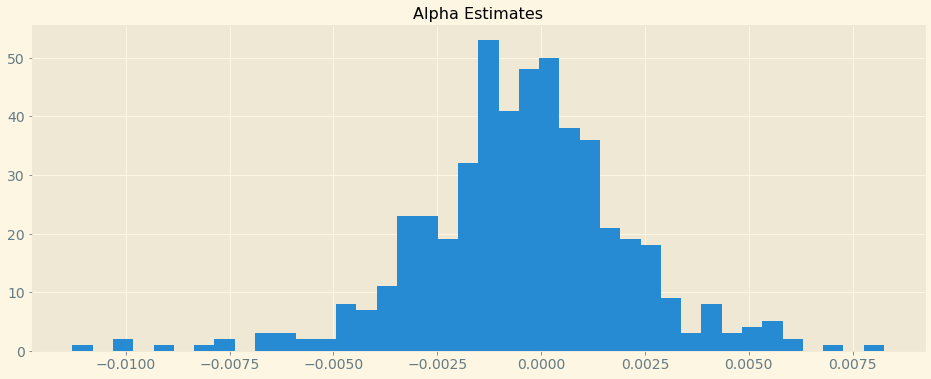

In [140]:
plt.hist(alphas,bins=40)
plt.title('Alpha Estimates')
plt.show()

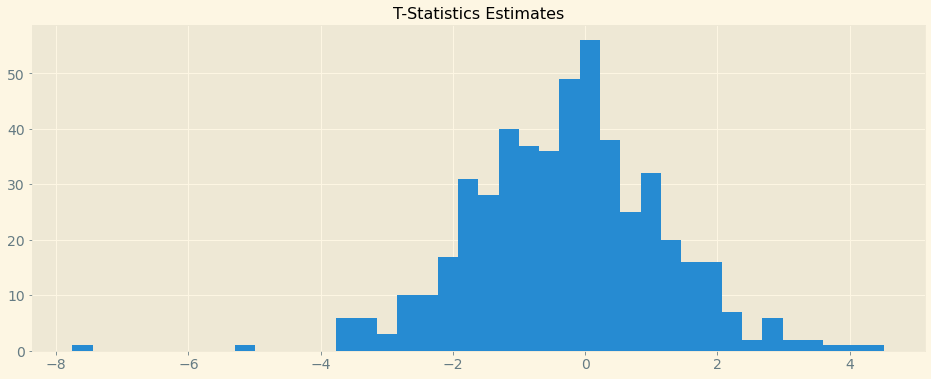

In [141]:
plt.hist(t_stats,bins=40)
plt.title('T-Statistics Estimates')
plt.show()

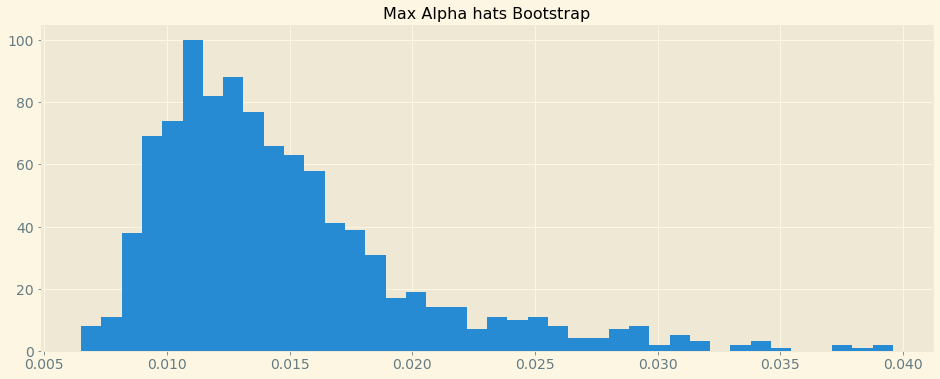

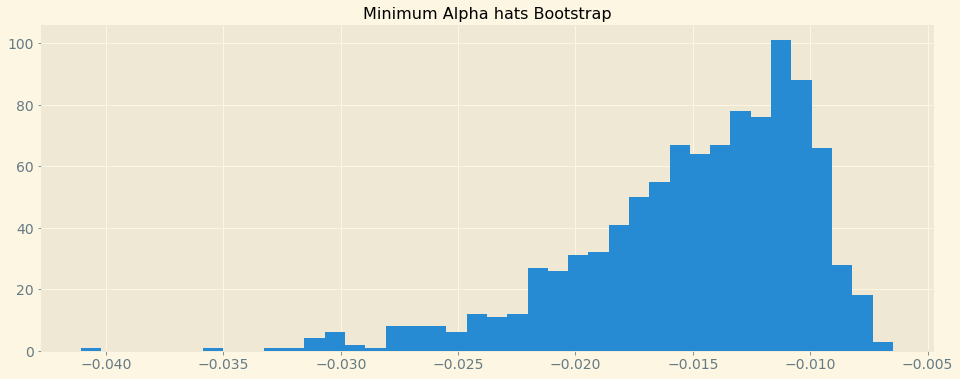

In [143]:
plt.hist(max_alphahat,bins=40)
plt.title('Max Alpha hats Bootstrap')
plt.show()

plt.hist(min_alphahat,bins=40)
plt.title('Minimum Alpha hats Bootstrap')
plt.show()


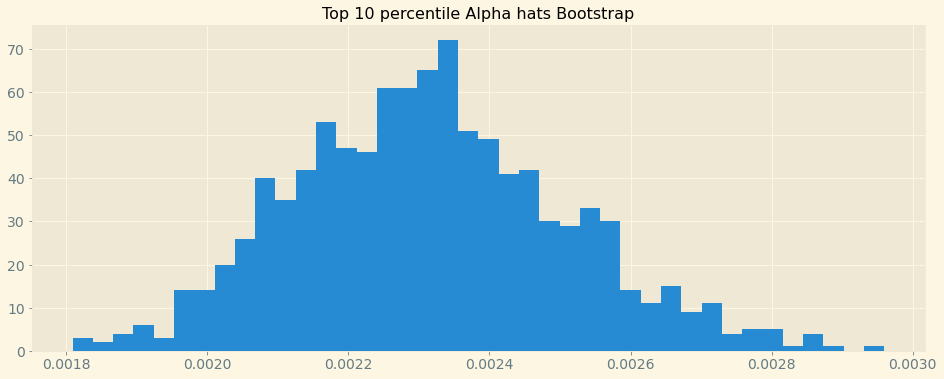

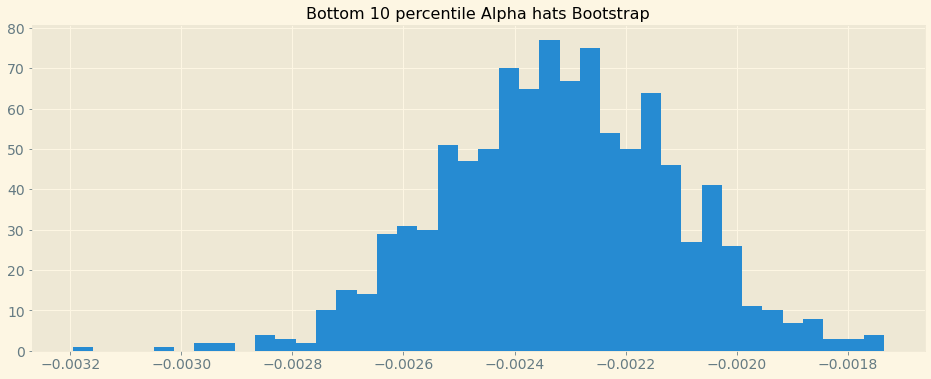

In [144]:
plt.hist(top10_alphahat,bins=40)
plt.title('Top 10 percentile Alpha hats Bootstrap')
plt.show()

plt.hist(bottom10_alphahat,bins=40)
plt.title('Bottom 10 percentile Alpha hats Bootstrap')
plt.show()

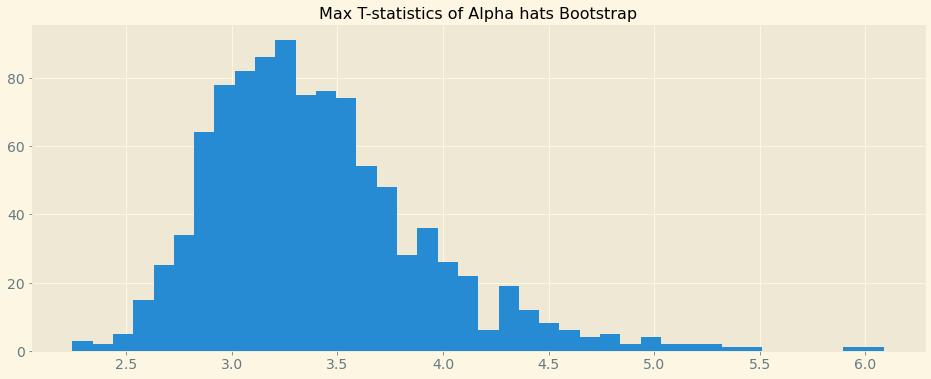

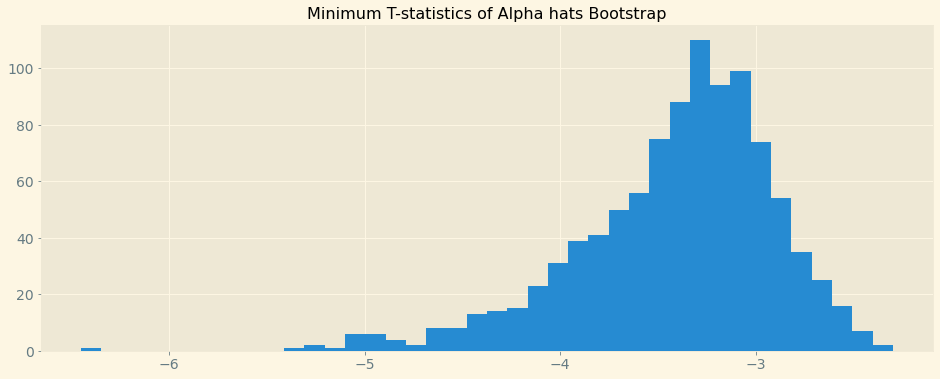

In [145]:
plt.hist(max_talphahat,bins=40)
plt.title('Max T-statistics of Alpha hats Bootstrap')
plt.show()

plt.hist(min_talphahat,bins=40)
plt.title('Minimum T-statistics of Alpha hats Bootstrap')
plt.show()


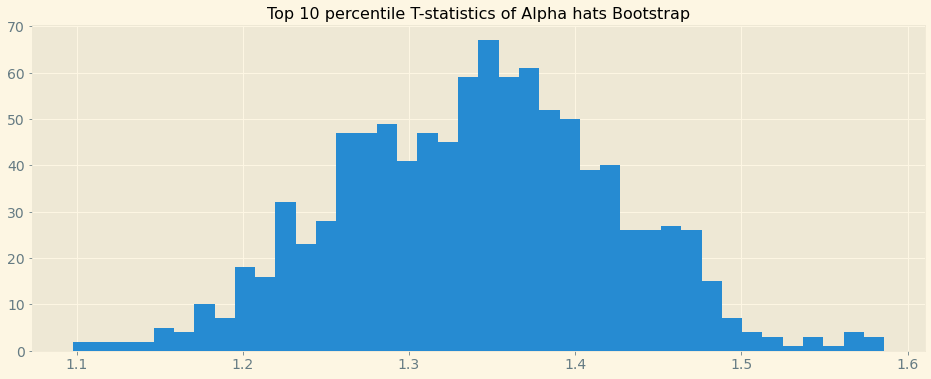

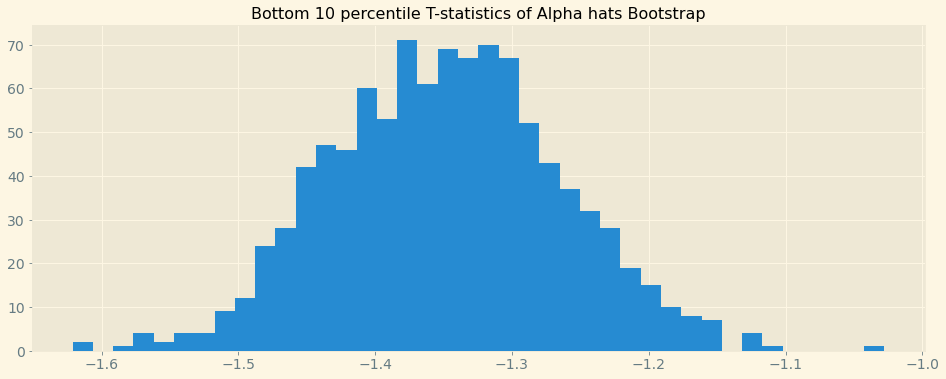

In [146]:
plt.hist(top10_talphahat,bins=40)
plt.title('Top 10 percentile T-statistics of Alpha hats Bootstrap')
plt.show()

plt.hist(bottom10_talphahat,bins=40)
plt.title('Bottom 10 percentile T-statistics of Alpha hats Bootstrap')
plt.show()